In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from skimage.io import imsave, imshow, imread
from skimage.color import rgb2lab, lab2rgb, grey2rgb, rgb2grey
from skimage.transform import resize
import os
from sklearn.model_selection import train_test_split
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input, decode_predictions

In [3]:
inception = InceptionResNetV2(weights='imagenet', include_top=True)

225214464/225209952 [==============================] - 1s 0us/step


## Standard autoencoder models testing:

### Model 1: AE non-fusion model

In [10]:
model = tf.keras.models.load_model(
    './gdrive/MyDrive/colorize_autoencoder_10000_50.model',
    custom_objects=None,
    compile=True)

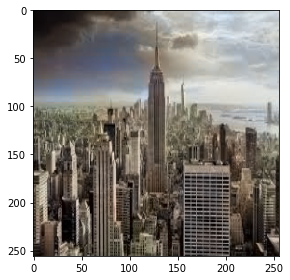

In [11]:
img1_color=[]
img1 = imread('1.png')
img1 = img1*(1.0/255)
img1 = resize(img1, (256, 256))
img1_color.append(img1)
img1_color = np.array(img1_color, dtype=float)
img1_color = rgb2lab(img1_color)[:,:,:,0]
img1_color = img1_color.reshape(img1_color.shape+(1,))

output1 = model.predict(img1_color)
output1 = output1*128
result = np.zeros((256, 256, 3))
result[:,:,0] = img1_color[0][:,:,0]
result[:,:,1:] = output1[0]
imshow(lab2rgb(result))

### Model 2: AE Fusion model:

In [5]:
model = tf.keras.models.load_model(
    './gdrive/MyDrive/colorize_autoencoder_fusion_10000_50.model',
    custom_objects=None,
    compile=True)

In [6]:
!mkdir fusion

In [7]:
img_name = "1.png"
img = imread(img_name)
img = img*(1.0/255)
img = grey2rgb(rgb2grey(img))
img = resize(img, (299, 299))
img = preprocess_input(img)
img = img.reshape((1,) + img.shape)
embed = inception.predict(img)
with open('./fusion/' + img_name, 'wb') as f:
    np.save(f, embed)

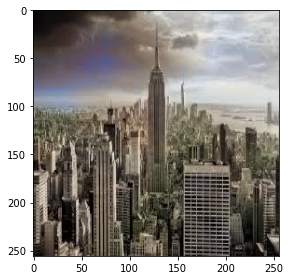

In [9]:
img1_color=[]
img1 = imread('1.png')
img1 = img1*(1.0/255)
img1 = resize(img1, (256,256))
img1_color.append(img1)
img1_color = np.array(img1_color, dtype=float)
img1_color = rgb2lab(img1_color)[:,:,:,0]
img1_color = img1_color.reshape(img1_color.shape+(1,))

img = imread('1.png')
img = img*(1.0/255)
img = grey2rgb(rgb2grey(img))
img = resize(img, (299,299))
img = preprocess_input(img)
img = img.reshape((1,) + img.shape)
embed = inception.predict(img)

output1 = model.predict([img1_color, embed])
output1 = output1*128
result = np.zeros((256, 256, 3))
result[:,:,0] = img1_color[0][:,:,0]
result[:,:,1:] = output1[0]
imshow(lab2rgb(result))

## Variational autoencoder model testing

In [12]:
class DataGenerator(tf.keras.utils.Sequence):
    """Generates data for Keras
    Sequence based data generator. Suitable for building data generator for training and prediction.
    """
    def __init__(self, list_IDs, image_path,
                 to_fit=True, batch_size=32, dim=(256, 256), shuffle=True, fusion=False, fusion_path='fusion/'):
        """Initialization

        :param list_IDs: list of all 'label' ids to use in the generator
        :param image_path: path to images location
        :param to_fit: True to return X and y, False to return X only
        :param batch_size: batch size at each iteration
        :param dim: tuple indicating image dimension
        :param shuffle: True to shuffle label indexes after every epoch
        :param fusion: True to return X and X_fusion, False returns X
        """
        self.list_IDs = list_IDs
        self.image_path = image_path
        self.to_fit = to_fit
        self.batch_size = batch_size
        self.dim = dim
        self.shuffle = shuffle
        self.fusion = fusion
        self.fusion_path = fusion_path
        self.on_epoch_end()

    def __len__(self):
        """Denotes the number of batches per epoch

        :return: number of batches per epoch
        """
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data

        :param index: index of the batch
        :return: X and y when fitting. X only when predicting
        """
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X = self._generate_X(list_IDs_temp)
        if self.to_fit:
            y = self._generate_y(list_IDs_temp)
            return X, y
        else:
            return X

    def on_epoch_end(self):
        """Updates indexes after each epoch

        """
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def _generate_X(self, list_IDs_temp):
        """Generates data containing batch_size images

        :param list_IDs_temp: list of label ids to load
        :return: batch of images
        """
        # Initialization
        X = np.empty((self.batch_size, *self.dim, 1))
        if self.fusion:
          X_fusion = np.empty((self.batch_size, 1000))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = self._load_lab_grayscale_image(self.image_path + ID)
            if self.fusion:
              X_fusion[i,] = self._load_fusion(self.fusion_path + ID)

        if self.fusion:
          return (X, X_fusion)
        else:
          return X

    def _generate_y(self, list_IDs_temp):
        """Generates data containing batch_size masks

        :param list_IDs_temp: list of label ids to load
        :return: batch if masks
        """
        y = np.empty((self.batch_size, *self.dim, 2))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            y[i,] = self._load_lab_color_image(self.image_path + ID)

        return y

    def _load_lab_grayscale_image(self, image_path):
      img = imread(image_path)
      img = img*(1.0/255)
      img = resize(img, (256, 256))
      if img.shape == (256, 256):
        img = grey2rgb(img)
      img = rgb2lab(img)
      img =(img[:,:,0]).reshape(img[:,:,0].shape+(1,))
      return img

    def _load_fusion(self, image_path):
      with open(image_path, 'rb') as f:
          embed = np.load(f)
          return embed 

    def _load_lab_color_image(self, image_path):
      img = imread(image_path)
      img = img*(1.0/255)
      img = resize(img, (256, 256))
      if img.shape == (256, 256):
        img = grey2rgb(img)
      img = rgb2lab(img)
      img = img[:,:,1:]*(1.0/128)
      return img

### Model 3: VAE Non-fusion model

In [13]:
vae = tf.keras.models.load_model(
    './gdrive/MyDrive/colorize_vae_10000_es_01.model',
    custom_objects=None,
    compile=True)

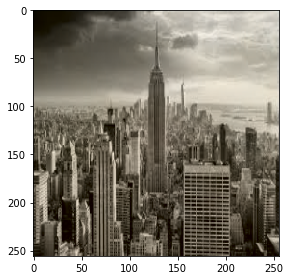

In [15]:
sample_datagen = DataGenerator(["1.png"], "./", fusion = False, batch_size = 1)
z_mean, z_log_var, z = vae.encoder(sample_datagen[0][0])
output = vae.decoder.predict(z[:1])*128
result = np.zeros((256, 256, 3))
result[:,:,0] =  sample_datagen[0][0][0,:,:,0]
result[:,:,1:] = output[0,:,:,:]
imshow(lab2rgb(result))

### Model 4: VAE + Fusion model

Note that I didn't save this model fully trained, but I have the backup model I saved loaded below.

In [17]:
vae = tf.keras.models.load_model(
    './gdrive/MyDrive/colorize_vae_fusion_10000_es_backup.model',
    custom_objects=None,
    compile=True)

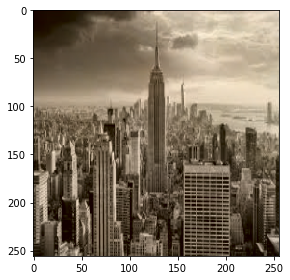

In [18]:
sample_datagen = DataGenerator(["1.png"], "./", fusion = True, batch_size = 1)
z_mean, z_log_var, z = vae.encoder(sample_datagen[0][0])
output = vae.decoder.predict(z[:1])*128
result = np.zeros((256, 256, 3))
result[:,:,0] =  sample_datagen[0][0][0][0,:,:,0]
result[:,:,1:] = output[0,:,:,:]
imshow(lab2rgb(result))